# Proyecto Final Tecnologías Emergentes

### Integrantes
    Fabio Buitrago
    Luis Alejandro Bravo Ferreira
    Ana María Ortegón Sepúlveda

### Objetivo
El objetivo del proyecto es resolver un problema contextualizado en sistemas de información geográfica realizando una clasificación de imágenes satelitales. Para esto se debe hacer uso del conjunto de imágenes adjunta a este proyecto, explorando los datos, codificando el modelo deseado y generando un reporte con los resultados de la solución construida.

## Descripción del problema

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
import os
import shutil
from sklearn.model_selection import train_test_split


from PIL import Image
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score


from tensorflow.keras.preprocessing.image import load_img, img_to_array

## Exploración y Descripción del conjunto de datos

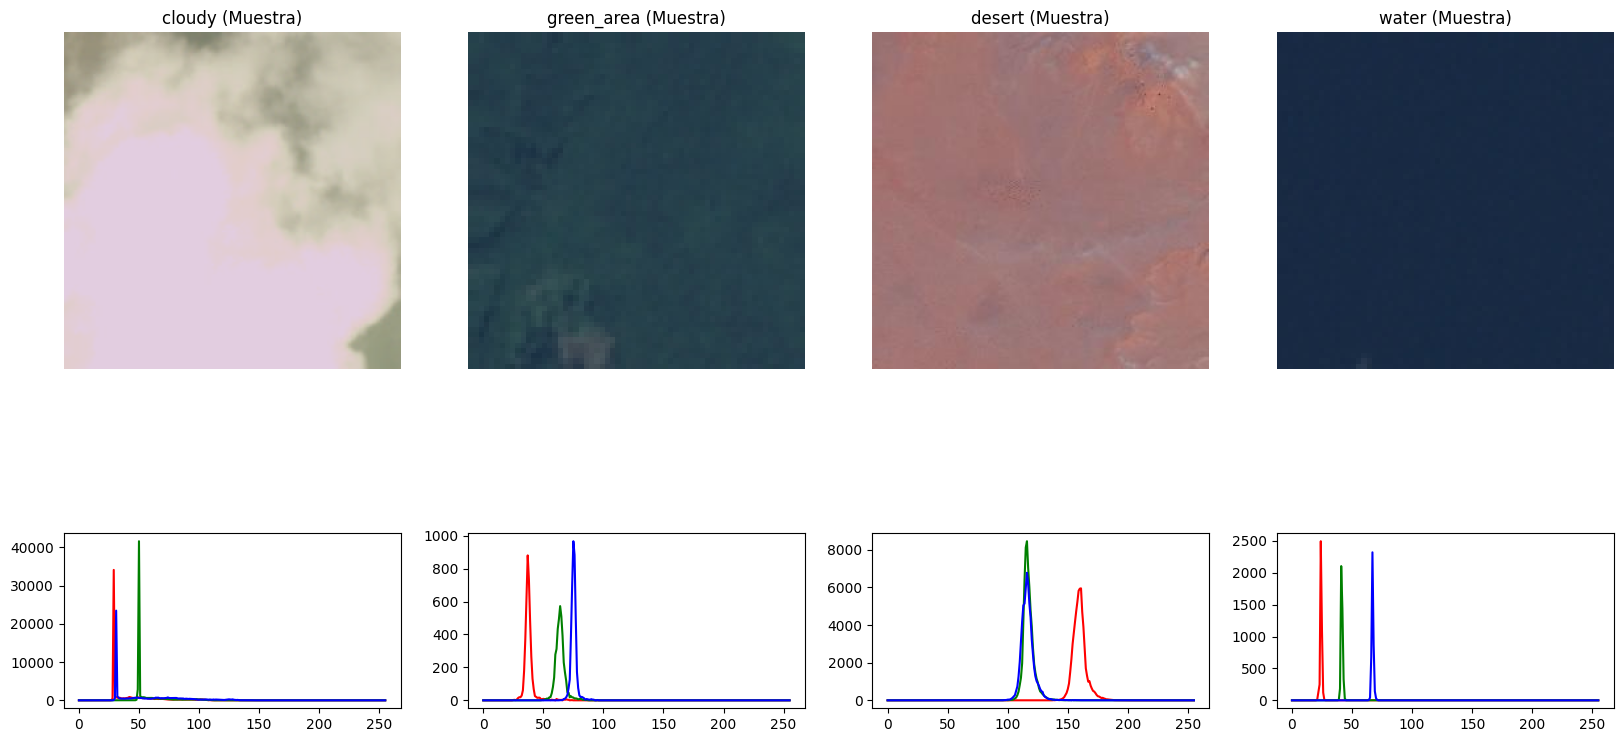

Categoría: cloudy
  Número total de imágenes: 1500
  Media de colores: [ 96.87189579  95.78548132 106.43908984   0.        ]
  Desviación estándar de colores: [10.04765355  9.0936603   9.50854375  0.        ]
Categoría: green_area
  Número total de imágenes: 1500
  Media de colores: [39.38843392 64.54512451 75.95175081]
  Desviación estándar de colores: [4.23094534 4.1827935  2.8178839 ]
Categoría: desert
  Número total de imágenes: 1131
  Media de colores: [182.97111916 154.92343724 127.462216  ]
  Desviación estándar de colores: [5.50970581 4.50098931 4.54488449]
Categoría: water
  Número total de imágenes: 1500
  Media de colores: [47.54668376 72.32665267 88.59800391]
  Desviación estándar de colores: [3.44621393 2.98507906 2.3174745 ]


In [18]:
"""
    Analiza y resume los datos de imágenes en diferentes categorías.

    La función itera sobre cada categoría especificada, accede a su correspondiente
    directorio dentro del directorio base y procesa todas las imágenes contenidas en él.
    Para cada imagen, calcula el promedio y desviación estándar de los colores, así como
    su histograma de color. Cada detalle de imagen es agregado a un DataFrame para
    posterior análisis. En caso de que no exista el directorio de alguna categoría, se
    maneja la excepción correspondiente.

    Args:
    - base_dir (str): Directorio base que contiene las carpetas de cada categoría.
    - categories (list of str): Lista de nombres de categorías para procesar.

    Returns:
    - dict: Un diccionario que contiene un resumen de datos para cada categoría, incluyendo
            un DataFrame con los detalles de las imágenes y el total de imágenes en esa categoría.
"""
def summarize_image_data(base_dir, categories):

    data_summary = {}
    for category in categories:
        category_path = os.path.join(base_dir, category)
        try:
            images = os.listdir(category_path)
            image_details = []
            for image_name in images:
                image_path = os.path.join(category_path, image_name)
                with Image.open(image_path) as img:
                    img_array = np.array(img)
                    mean_colors = np.mean(img_array, axis=(0, 1)) if img_array.ndim == 3 else np.mean(img_array)
                    std_colors = np.std(img_array, axis=(0, 1)) if img_array.ndim == 3 else np.std(img_array)
                    hist_colors = [np.histogram(img_array[:, :, i], bins=256, range=(0, 256))[0]
                                   for i in range(img_array.shape[-1])] if img_array.ndim == 3 else np.histogram(img_array, bins=256, range=(0, 256))[0]
                    image_details.append({
                        'filename': image_name,
                        'width': img.width,
                        'height': img.height,
                        'mode': img.mode,
                        'mean_colors': mean_colors,
                        'std_colors': std_colors,
                        'histogram': hist_colors
                    })
            data_summary[category] = {
                'count': len(images),
                'details': pd.DataFrame(image_details)
            }
        except FileNotFoundError:
            print(f"No se encontró la carpeta: {category_path}")
    return data_summary

def show_sample_images_and_histograms(data_summary, base_dir, categories):
    fig, axs = plt.subplots(2, len(categories), figsize=(20, 10), gridspec_kw={'height_ratios': [3, 1]})
    for i, category in enumerate(categories):
        if data_summary.get(category):
            image_path = os.path.join(base_dir, category, data_summary[category]['details'].iloc[0]['filename'])
            img = Image.open(image_path)
            img_array = np.array(img)
            axs[0, i].imshow(img)
            axs[0, i].set_title(f"{category} (Muestra)")
            axs[0, i].axis('off')

            if img_array.ndim == 3:
                for j in range(3):
                    axs[1, i].plot(data_summary[category]['details'].iloc[0]['histogram'][j], color=['r', 'g', 'b'][j])
            else:
                axs[1, i].plot(data_summary[category]['details'].iloc[0]['histogram'], color='gray')
    plt.show()

base_dir = 'data'
categories = ['cloudy', 'green_area', 'desert', 'water']

data_summary = summarize_image_data(base_dir, categories)
show_sample_images_and_histograms(data_summary, base_dir, categories)

for category in categories:
    if data_summary.get(category):
        print(f"Categoría: {category}")
        print(f"  Número total de imágenes: {data_summary[category]['count']}")
        print(f"  Media de colores: {data_summary[category]['details']['mean_colors'].mean()}")
        print(f"  Desviación estándar de colores: {data_summary[category]['details']['std_colors'].mean()}")


## Procedimiento

In [19]:
"""
    Divide las imágenes de una categoría en conjuntos de entrenamiento y prueba,
    y copia las imágenes correspondientes en los directorios respectivos.

    Args:
        category (str): El nombre de la categoría (subdirectorio) de las imágenes.
        source_dir (str): La ruta del directorio fuente que contiene las imágenes.
        train_dir (str): La ruta del directorio principal para las imágenes de entrenamiento.
        test_dir (str): La ruta del directorio principal para las imágenes de prueba.
        train_size (float, optional): Proporción de las imágenes que se utilizarán para el entrenamiento. 
                                      El resto se utilizará para la prueba. Por defecto es 0.8.
"""
def split_and_copy_images(category, source_dir, train_dir, test_dir, train_size=0.8):
    images = os.listdir(source_dir)
    train_images, test_images = train_test_split(images, train_size=train_size, random_state=42)
    
    category_train_dir = os.path.join(train_dir, category)
    category_test_dir = os.path.join(test_dir, category)
    
    os.makedirs(category_train_dir, exist_ok=True)
    os.makedirs(category_test_dir, exist_ok=True)
    
    for image in train_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(category_train_dir, image)
        shutil.copy(src_path, dst_path)
    
    for image in test_images:
        src_path = os.path.join(source_dir, image)
        dst_path = os.path.join(category_test_dir, image)
        shutil.copy(src_path, dst_path)

"""
    Prepara los generadores de datos de imágenes para entrenamiento y prueba.

    Args:
        cloudy_path (str): Ruta del directorio que contiene las imágenes de la categoría 'cloudy'.
        desert_path (str): Ruta del directorio que contiene las imágenes de la categoría 'desert'.
        green_path (str): Ruta del directorio que contiene las imágenes de la categoría 'green'.
        water_path (str): Ruta del directorio que contiene las imágenes de la categoría 'water'.
        base_dir (str, optional): Ruta base donde se crearán los directorios de entrenamiento y prueba. 
                                  Por defecto es './data/'.
        train_size (float, optional): Proporción de las imágenes que se utilizarán para el entrenamiento. 
                                      El resto se utilizará para la prueba. Por defecto es 0.8.
        new_img_width (int, optional): Ancho al que se redimensionarán las imágenes. Por defecto es 64.
        new_img_height (int, optional): Altura a la que se redimensionarán las imágenes. Por defecto es 64.
        batch_size (int, optional): Tamaño del lote para los generadores. Por defecto es 32.

    Returns:
        tuple: Generadores de datos de imágenes para entrenamiento y prueba.
"""
def prepare_data_generators(cloudy_path, desert_path, green_path, water_path, base_dir='./data/', train_size=0.8, new_img_width=64, new_img_height=64, batch_size=32):
    # Definir rutas para los datasets divididos
    train_dir = os.path.join(base_dir, 'training_set')
    test_dir = os.path.join(base_dir, 'test_set')

    # Crear directorios para entrenamiento y prueba
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    # Lista de categorías y sus rutas correspondientes
    categories = {
        'cloudy': cloudy_path,
        'desert': desert_path,
        'green': green_path,
        'water': water_path
    }

    # Dividir y copiar imágenes para cada categoría
    for category, path in categories.items():
        split_and_copy_images(category, path, train_dir, test_dir, train_size)

    # Crear generadores de datos de imágenes para entrenamiento y prueba
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    # Flujo desde el directorio y redimensionamiento de las imágenes a (64, 64)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(new_img_width, new_img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(new_img_width, new_img_height),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_generator, test_generator

# Dimensiones de las imágenes
new_img_width=64
new_img_height=64

# Tamaño del lote
batch_size = 32

# Definir rutas de los datasets originales
cloudy_path = "./data/cloudy"
desert_path = "data/desert"
green_path = "data/green_area"
water_path = "data/water"

# Uso de la función
train_generator, test_generator = prepare_data_generators(cloudy_path, desert_path, green_path, water_path, batch_size = batch_size)

Found 5403 images belonging to 4 classes.
Found 2026 images belonging to 4 classes.


## Arquitectura #1

In [20]:
"""
    Define y compila un modelo CNN para la clasificación de imágenes.

    Args:
        input_shape (tuple, optional): Forma de las imágenes de entrada. Por defecto es (64, 64, 3).
        num_classes (int, optional): Número de clases de salida. Por defecto es 4.
        learning_rate (float, optional): Tasa de aprendizaje para el optimizador. Por defecto es 0.00001.

    Returns:
        Model: Modelo compilado de Keras.
"""
def create_cnn_model(input_shape=(64, 64, 3), num_classes=4, learning_rate=0.00001):
    
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    custom_optimizer = Adam(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Mostrar el resumen del modelo
    model.summary()
    
    return model

# Uso de la función
model = create_cnn_model()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,837,572 (22.27 MB)

 Trainable params: 5,836,612 (22.26 MB)

 Non-trainable params: 960 (3.75 KB)

## Arquitectura #2

In [21]:
def create_cnn_model_v2(input_shape=(64, 64, 3), num_classes=4, learning_rate=0.00001):
    """
    Define y compila un segundo modelo CNN para la clasificación de imágenes.

    Args:
        input_shape (tuple, optional): Forma de las imágenes de entrada. Por defecto es (64, 64, 3).
        num_classes (int, optional): Número de clases de salida. Por defecto es 4.
        learning_rate (float, optional): Tasa de aprendizaje para el optimizador. Por defecto es 0.00001.

    Returns:
        Model: Modelo compilado de Keras.
    """
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), activation='relu', padding="same")(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(64, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(128, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(256, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(512, (3, 3), activation='relu', padding="same")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    
    x = Conv2D(1024, (3, 3), activation='relu', padding="same")(x)
    x = Conv2D(1024, (3, 3), activation='relu', padding="same")(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    custom_optimizer = Adam(learning_rate=learning_rate)

    # Compilar el modelo
    model.compile(optimizer=custom_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Mostrar el resumen del modelo
    model.summary()
    
    return model

# Uso de la función
model_v2 = create_cnn_model_v2()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 22,619,396 (86.29 MB)

 Trainable params: 22,617,412 (86.28 MB)

 Non-trainable params: 1,984 (7.75 KB)

### Función para matrices de confusión y entrenamiento

In [22]:
"""
    Evalúa el modelo CNN utilizando el generador de datos de prueba, calcula varias métricas de rendimiento,
    y genera una matriz de confusión visualmente atractiva.

    Args:
        model (Model): Modelo de Keras entrenado.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        train_generator (DirectoryIterator): Generador de datos de entrenamiento (usado para obtener índices de clase).

    Returns:
        dict: Diccionario que contiene la matriz de confusión, el informe de clasificación y métricas adicionales (precisión, recall, F1 score).
"""
def evaluate_and_plot_confusion_matrix(model, test_generator, train_generator):
    
    # Reiniciar el generador de prueba
    test_generator.reset()
    
    # Realizar predicciones sobre el conjunto de prueba
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    
    # Obtener las etiquetas predichas y verdaderas
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    
    # Obtener los índices de clase y nombres de clase
    class_indices = train_generator.class_indices
    class_names = list(class_indices.keys())
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    # Generar el heatmap de la matriz de confusión
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Matriz de Confusión')
    plt.xlabel('Etiqueta Predicha')
    plt.ylabel('Etiqueta Verdadera')
    plt.show()
    
    # Calcular el informe de clasificación
    class_report = classification_report(true_labels, predicted_labels, target_names=class_names)
    print('Informe de Clasificación')
    print(class_report)
    
    # Calcular métricas adicionales
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted', zero_division=1)
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    print(f'Precisión: {accuracy}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    
    # Retornar las métricas calculadas en un diccionario
    return {
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }


"""
    Entrena el modelo CNN con los generadores de datos de entrenamiento y prueba.

    Args:
        model (Model): Modelo de Keras a entrenar.
        train_generator (DirectoryIterator): Generador de datos de entrenamiento.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        epochs (int, optional): Número de épocas para entrenar el modelo. Por defecto es 10.

    Returns:
        tuple: Historia del entrenamiento y tiempo total de entrenamiento en segundos.
"""
def train_cnn_model(model, train_generator, test_generator, epochs=10):

    start_time = time.time()
    
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=test_generator
    )
    
    end_time = time.time()
    total_time = end_time - start_time
    
    return history, total_time

## Modelo 1

### Entrenamiento del modelo 1 por 10 épocas

In [ ]:
# Uso de la función
history, training_time = train_cnn_model(model, train_generator, test_generator, epochs=10)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time} segundos")

Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 310ms/step - accuracy: 0.7161 - loss: 0.8207 - val_accuracy: 0.2662 - val_loss: 1.3785
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 306ms/step - accuracy: 0.9139 - loss: 0.2268 - val_accuracy: 0.2662 - val_loss: 1.4314
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9274 - loss: 0.1757 - val_accuracy: 0.3869 - val_loss: 1.5398
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9532 - loss: 0.1242 - val_accuracy: 0.6007 - val_loss: 1.0729
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 303ms/step - accuracy: 0.9664 - loss: 0.0958 - val_accuracy: 0.9459 - val_loss: 0.1435
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.9679 - loss: 0.0841 - val_accuracy: 0.9574 - val_loss: 0.1239
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.9676 - loss: 0.0897 - val_accuracy: 0.9716 - val_loss: 0.0705
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 48s 336ms/step - accuracy: 0.9634 - loss: 0.1009 - val

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step


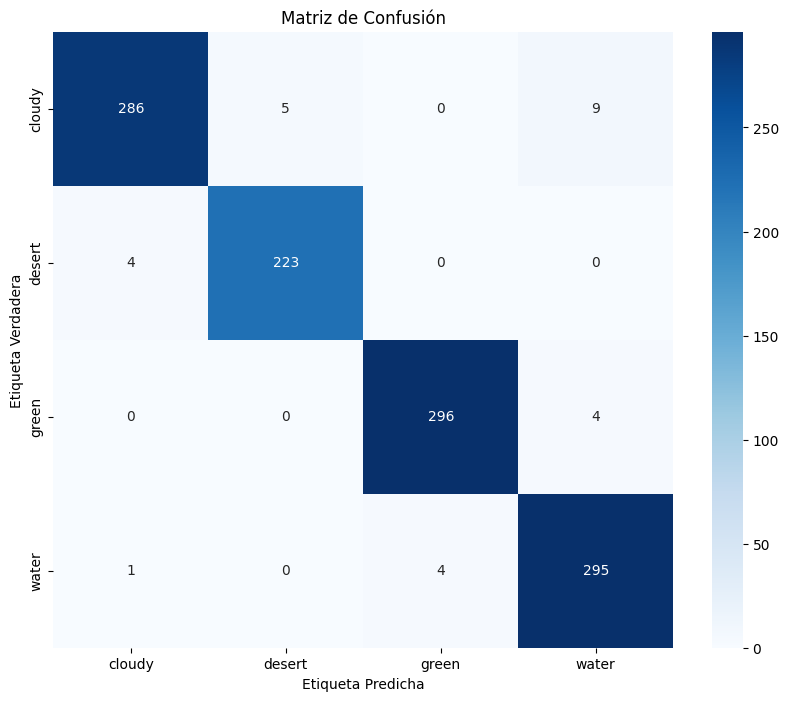

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       0.98      0.95      0.97       300
      desert       0.98      0.98      0.98       227
       green       0.99      0.99      0.99       300
       water       0.96      0.98      0.97       300

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127

Precisión: 0.9760425909494232
Recall: 0.9760425909494232
F1 Score: 0.9760280755206392


In [ ]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

### Entrenamiento del modelo 1 por 25 épocas

In [ ]:
# Uso de la función
history, training_time = train_cnn_model(model, train_generator, test_generator, epochs=25)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time} segundos")

Epoch 1/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 332ms/step - accuracy: 0.9753 - loss: 0.0715 - val_accuracy: 0.9831 - val_loss: 0.0451
Epoch 2/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 46s 328ms/step - accuracy: 0.9765 - loss: 0.0658 - val_accuracy: 0.9805 - val_loss: 0.0562
Epoch 3/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 381ms/step - accuracy: 0.9733 - loss: 0.0700 - val_accuracy: 0.9716 - val_loss: 0.0810
Epoch 4/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.9820 - loss: 0.0579 - val_accuracy: 0.9876 - val_loss: 0.0437
Epoch 5/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - accuracy: 0.9805 - loss: 0.0535 - val_accuracy: 0.9601 - val_loss: 0.1233
Epoch 6/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 52s 365ms/step - accuracy: 0.9668 - loss: 0.0815 - val_accuracy: 0.9432 - val_loss: 0.1843
Epoch 7/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 54s 382ms/step - accuracy: 0.9771 - loss: 0.0674 - val_accuracy: 0.9778 - val_loss: 0.0637
Epoch 8/25
141/141 ━━━━━━━━━━━━━━━━━━━━ 55s 385ms/step - accuracy: 0.9800 - loss: 0

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step


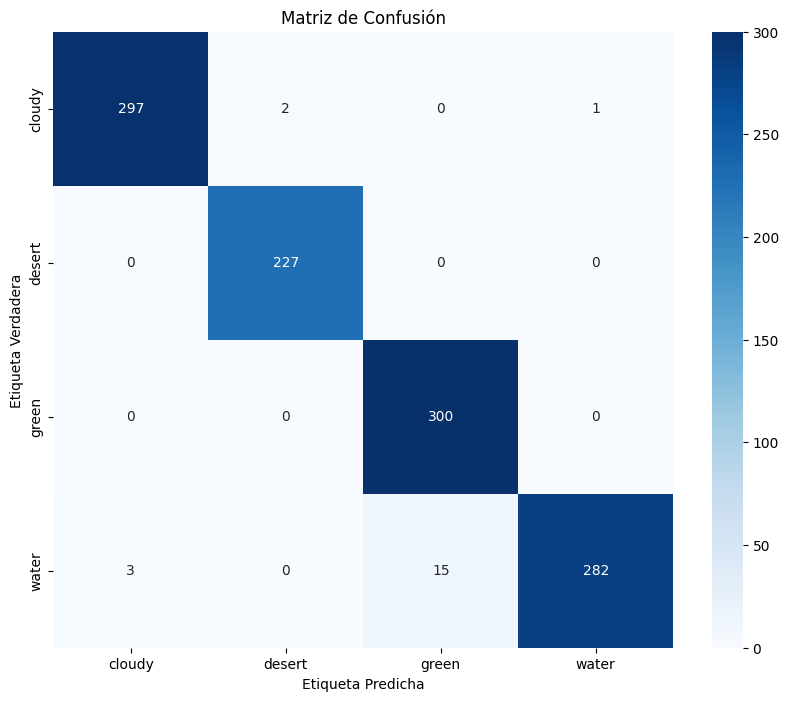

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       0.99      0.99      0.99       300
      desert       0.99      1.00      1.00       227
       green       0.95      1.00      0.98       300
       water       1.00      0.94      0.97       300

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127

Precisión: 0.9813664596273292
Recall: 0.9813664596273292
F1 Score: 0.9812868654452421


In [ ]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

### Entrenamiento del modelo 1 por 50 épocas

In [ ]:
# Uso de la función
history, training_time = train_cnn_model(model, train_generator, test_generator, epochs=50)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time} segundos")

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 332ms/step - accuracy: 0.9893 - loss: 0.0317 - val_accuracy: 0.9707 - val_loss: 0.0846
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 335ms/step - accuracy: 0.9902 - loss: 0.0233 - val_accuracy: 0.9814 - val_loss: 0.0527
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 47s 330ms/step - accuracy: 0.9894 - loss: 0.0319 - val_accuracy: 0.9370 - val_loss: 0.1934
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 45s 315ms/step - accuracy: 0.9853 - loss: 0.0463 - val_accuracy: 0.9885 - val_loss: 0.0398
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 49s 342ms/step - accuracy: 0.9859 - loss: 0.0427 - val_accuracy: 0.9725 - val_loss: 0.0901
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 44s 308ms/step - accuracy: 0.9866 - loss: 0.0324 - val_accuracy: 0.9787 - val_loss: 0.0627
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 50s 355ms/step - accuracy: 0.9904 - loss: 0.0324 - val_accuracy: 0.9636 - val_loss: 0.1345
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 56s 398ms/step - accuracy: 0.9898 - loss: 0

36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step


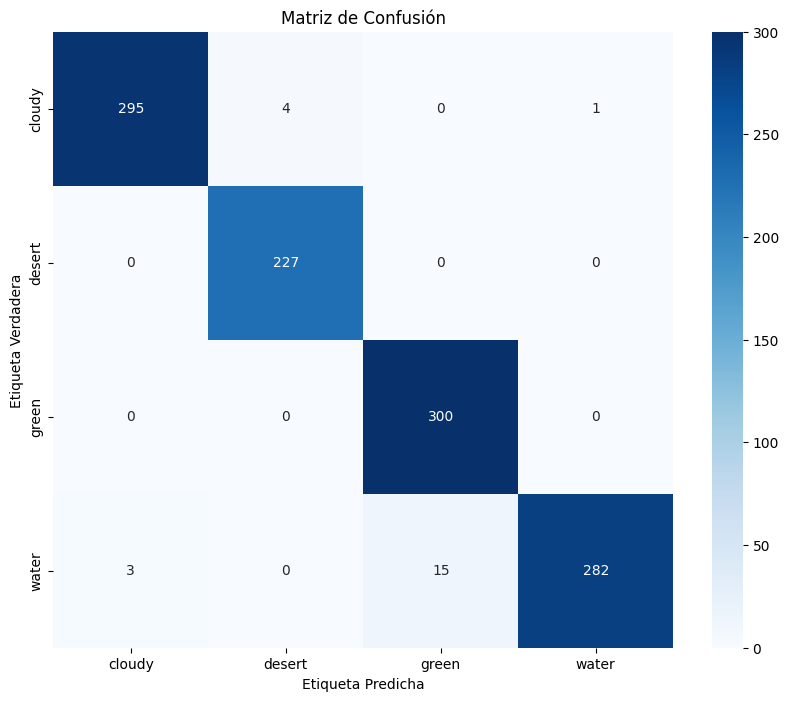

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       0.99      0.98      0.99       300
      desert       0.98      1.00      0.99       227
       green       0.95      1.00      0.98       300
       water       1.00      0.94      0.97       300

    accuracy                           0.98      1127
   macro avg       0.98      0.98      0.98      1127
weighted avg       0.98      0.98      0.98      1127

Precisión: 0.9795918367346939
Recall: 0.9795918367346939
F1 Score: 0.9795119793383873


In [ ]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

## Modelo 2

### Entrenamiento del modelo 2 por 10 épocas

In [23]:
# Uso de la función
history_v2, training_time_v2 = train_cnn_model(model_v2, train_generator, test_generator, epochs=10)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time_v2} segundos")

Epoch 1/10


c:\Users\Luis Alejandro\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


169/169 ━━━━━━━━━━━━━━━━━━━━ 60s 333ms/step - accuracy: 0.7649 - loss: 0.6580 - val_accuracy: 0.2685 - val_loss: 1.3907
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 224ms/step - accuracy: 0.9511 - loss: 0.1467 - val_accuracy: 0.2685 - val_loss: 1.4892
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 229ms/step - accuracy: 0.9628 - loss: 0.1049 - val_accuracy: 0.3460 - val_loss: 1.4614
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 39s 228ms/step - accuracy: 0.9653 - loss: 0.0913 - val_accuracy: 0.8963 - val_loss: 0.2589
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.9684 - loss: 0.0948 - val_accuracy: 0.9126 - val_loss: 0.2198
Epoch 6/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.9657 - loss: 0.0977 - val_accuracy: 0.9872 - val_loss: 0.0434
Epoch 7/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 265ms/step - accuracy: 0.9712 - loss: 0.0817 - val_accuracy: 0.9289 - val_loss: 0.2102
Epoch 8/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 245ms/step - accuracy: 0.9705 - loss: 0.0923 - val

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step


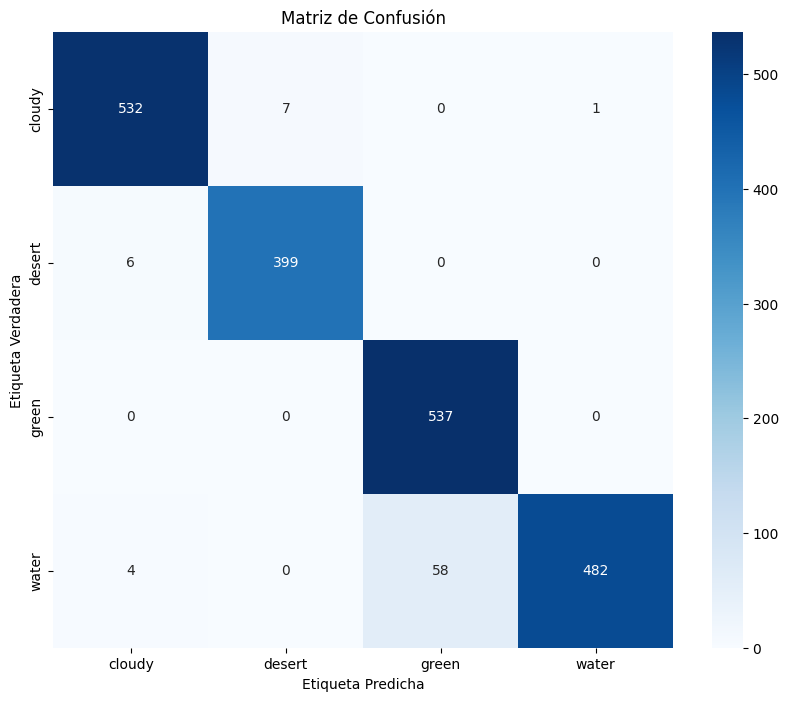

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       0.98      0.99      0.98       540
      desert       0.98      0.99      0.98       405
       green       0.90      1.00      0.95       537
       water       1.00      0.89      0.94       544

    accuracy                           0.96      2026
   macro avg       0.97      0.96      0.96      2026
weighted avg       0.97      0.96      0.96      2026

Precisión: 0.9624876604146101
Recall: 0.9624876604146101
F1 Score: 0.9623097398487244


In [24]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model_v2, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

### Entrenamiento del modelo 2 por 25 épocas

In [25]:
# Uso de la función
history_v2, training_time_v2 = train_cnn_model(model_v2, train_generator, test_generator, epochs=25)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time_v2} segundos")

Epoch 1/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 238ms/step - accuracy: 0.9752 - loss: 0.0729 - val_accuracy: 0.9842 - val_loss: 0.0520
Epoch 2/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 247ms/step - accuracy: 0.9813 - loss: 0.0493 - val_accuracy: 0.9763 - val_loss: 0.0598
Epoch 3/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 45s 262ms/step - accuracy: 0.9816 - loss: 0.0510 - val_accuracy: 0.9847 - val_loss: 0.0523
Epoch 4/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.9740 - loss: 0.0746 - val_accuracy: 0.9640 - val_loss: 0.1264
Epoch 5/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 42s 249ms/step - accuracy: 0.9790 - loss: 0.0634 - val_accuracy: 0.9620 - val_loss: 0.1093
Epoch 6/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 236ms/step - accuracy: 0.9861 - loss: 0.0475 - val_accuracy: 0.9719 - val_loss: 0.0748
Epoch 7/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.9838 - loss: 0.0525 - val_accuracy: 0.9842 - val_loss: 0.0415
Epoch 8/25
169/169 ━━━━━━━━━━━━━━━━━━━━ 40s 235ms/step - accuracy: 0.9842 - loss: 0

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step


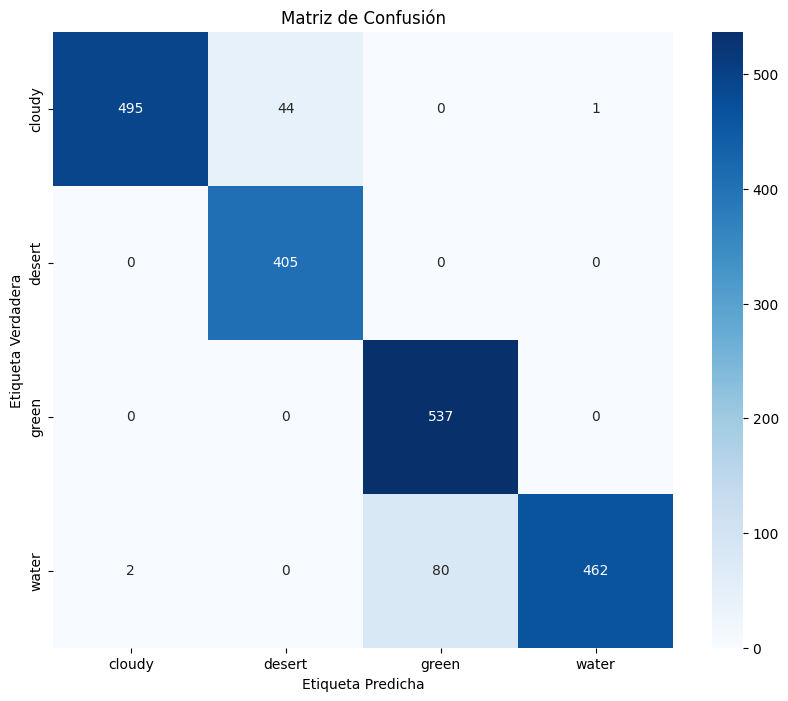

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       1.00      0.92      0.95       540
      desert       0.90      1.00      0.95       405
       green       0.87      1.00      0.93       537
       water       1.00      0.85      0.92       544

    accuracy                           0.94      2026
   macro avg       0.94      0.94      0.94      2026
weighted avg       0.94      0.94      0.94      2026

Precisión: 0.937314906219151
Recall: 0.937314906219151
F1 Score: 0.9371144493987066


In [26]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model_v2, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

### Entrenamiento del modelo 2 por 50 épocas

In [27]:
# Uso de la función
history_v2, training_time_v2 = train_cnn_model(model_v2, train_generator, test_generator, epochs=50)

# Mostrar el tiempo total de entrenamiento
print(f"Tiempo total de entrenamiento: {training_time_v2} segundos")

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.9910 - loss: 0.0254 - val_accuracy: 0.9590 - val_loss: 0.1531
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 219ms/step - accuracy: 0.9865 - loss: 0.0414 - val_accuracy: 0.9719 - val_loss: 0.0716
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 218ms/step - accuracy: 0.9922 - loss: 0.0261 - val_accuracy: 0.9926 - val_loss: 0.0246
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.9902 - loss: 0.0292 - val_accuracy: 0.9729 - val_loss: 0.0712
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 217ms/step - accuracy: 0.9918 - loss: 0.0276 - val_accuracy: 0.9615 - val_loss: 0.0965
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.9903 - loss: 0.0295 - val_accuracy: 0.9501 - val_loss: 0.1189
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 221ms/step - accuracy: 0.9901 - loss: 0.0273 - val_accuracy: 0.9872 - val_loss: 0.0523
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 38s 222ms/step - accuracy: 0.9839 - loss: 0

64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


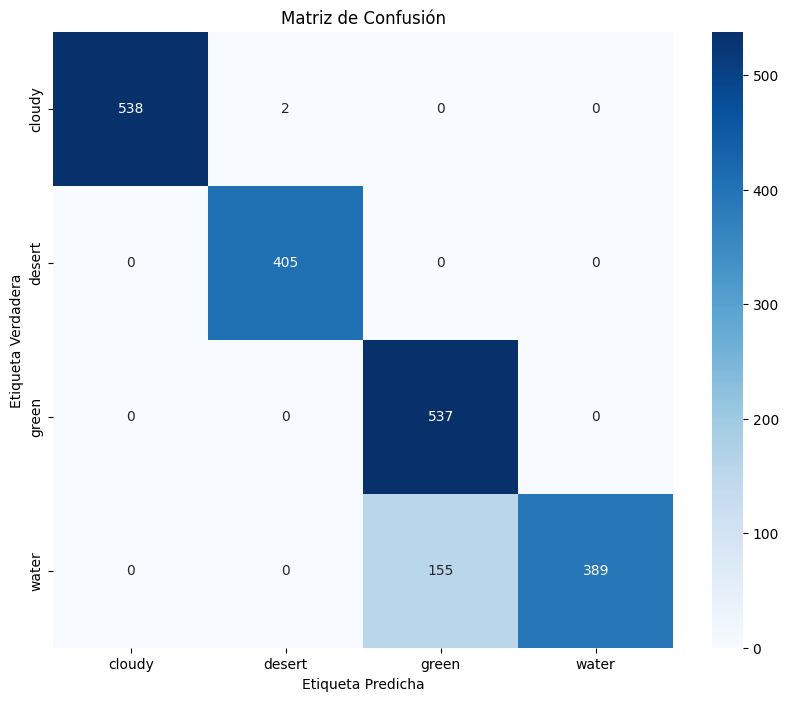

Informe de Clasificación
              precision    recall  f1-score   support

      cloudy       1.00      1.00      1.00       540
      desert       1.00      1.00      1.00       405
       green       0.78      1.00      0.87       537
       water       1.00      0.72      0.83       544

    accuracy                           0.92      2026
   macro avg       0.94      0.93      0.93      2026
weighted avg       0.94      0.92      0.92      2026

Precisión: 0.922507403751234
Recall: 0.922507403751234
F1 Score: 0.9209771374443675


In [28]:
# Uso de la función
evaluation_metrics = evaluate_and_plot_confusion_matrix(model_v2, test_generator, train_generator)

# Acceso a las métricas
conf_matrix = evaluation_metrics['confusion_matrix']
class_report = evaluation_metrics['classification_report']
accuracy = evaluation_metrics['accuracy']
precision = evaluation_metrics['precision']
recall = evaluation_metrics['recall']
f1 = evaluation_metrics['f1_score']

# Ver ejemplos de instancias mal clasificadas

In [ ]:
"""
    Muestra las imágenes mal clasificadas junto con sus etiquetas verdaderas y predichas.

    Args:
        model (Model): El modelo de Keras entrenado.
        test_generator (DirectoryIterator): Generador de datos de prueba.
        class_names (list): Lista de nombres de clases.
        num_images (int): Número de imágenes mal clasificadas a mostrar. Por defecto son 20.
"""
def display_misclassified_images(model, test_generator, class_names, num_images=20):

    # Reiniciar el generador de prueba
    test_generator.reset()
    
    # Realizar predicciones sobre el conjunto de prueba
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
    
    # Obtener las etiquetas predichas y verdaderas
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = test_generator.classes
    
    # Encontrar índices de imágenes mal clasificadas
    misclassified_indices = np.where(predicted_labels != true_labels)[0]
    
    # Mostrar algunas imágenes mal clasificadas
    num_display = min(num_images, len(misclassified_indices))
    plt.figure(figsize=(15, num_display * 2))
    
    for i, idx in enumerate(misclassified_indices[:num_display]):
        # Obtener ruta de la imagen
        img_path = test_generator.filepaths[idx]
        
        # Cargar la imagen
        img = load_img(img_path, target_size=(test_generator.target_size))
        img_array = img_to_array(img)
        
        # Mostrar la imagen
        plt.subplot(num_display, 1, i + 1)
        plt.imshow(img_array.astype("uint8"))
        plt.axis('off')
        
        # Etiquetas verdadera y predicha
        true_label = class_names[true_labels[idx]]
        predicted_label = class_names[predicted_labels[idx]]
        plt.title(f'True: {true_label} | Predicted: {predicted_label}')
    
    plt.tight_layout()
    plt.show()

# Uso de la función
class_names = list(train_generator.class_indices.keys())
display_misclassified_images(model, test_generator, class_names)


## Conclusiones